In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(0)  # For reproducibility


In [12]:
nodes = pd.DataFrame(columns= ["id", "area", "lat", "lon", "exists", "comment"])
N = 10 # number of nodes
areas = ["A1", "A2"]

for i in range(N):
    lat = np.random.uniform(0, 10)
    lon = np.random.uniform(0, 10)
    area = areas[0] if lon <= 5 else areas[1]
    exists = np.random.choice([True, False])
    comment = "Acivte" if exists else ""
    nodes.loc[i] = [i, area, lat, lon, exists, comment]

In [13]:
import os
folder = os.getcwd()
print(folder)
data_folder = os.path.join(folder, "data")
print(data_folder)
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
nodes.to_csv(os.path.join(data_folder, "nodes.csv"), index=False)


c:\Users\tinus\OneDrive\Dokumenter\0 Master\code\specialization_project\market_clearing_quick
c:\Users\tinus\OneDrive\Dokumenter\0 Master\code\specialization_project\market_clearing_quick\data


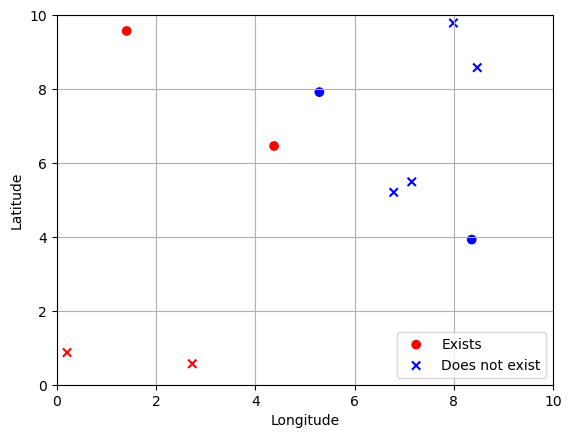

In [14]:
# Plot the nodes on a 2d plane with different colors for different areas and different shapes for existing and non-existing nodes
# Make sure to add a legend to the plot

plt.figure()
area_to_color = {"A1": "red", "A2": "blue"}
colormap = np.array([area_to_color[area] for area in nodes["area"]])
plt.scatter(nodes[nodes["exists"]]["lon"], nodes[nodes["exists"]]["lat"], c=colormap[nodes["exists"]], marker="o", label="Exists")
plt.scatter(nodes[~nodes["exists"]]["lon"], nodes[~nodes["exists"]]["lat"], c=colormap[~nodes["exists"]], marker='x', label="Does not exist")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.legend()
plt.show()

In [17]:
import pandas as pd
import numpy as np

# Generator parameters
num_generators = 8  # You can change this number as required
types = ['solar', 'coal', 'oil']  # Possible types of generators
areas = ['A1', 'A2']  # Area identifiers

# Generate random data for generators

data = []
for _ in range(num_generators):
    generator_type = np.random.choice(types)
    node_id = np.random.choice(nodes["id"].values)
    area = np.random.choice(areas)
    
    if generator_type == 'solar':
        pmax = np.random.uniform(50, 100)  # Smaller capacity for solar
        pmin = 0  # Renewable energy, minimum output is 0
        MC = np.random.uniform(5, 10)  # Solar has low marginal cost
        CO2 = 0  # No CO2 emissions for solar
    elif generator_type == 'coal':
        pmax = np.random.uniform(200, 400)  # Coal power plant capacity
        pmin = pmax * 0.3  # Coal often has a high minimum generation level
        MC = np.random.uniform(20, 40)  # Higher marginal cost
        CO2 = np.random.uniform(0.8, 1.2)  # Tons of CO2 per MWh
    else:  # 'oil'
        pmax = np.random.uniform(100, 200)  # Oil generator capacity
        pmin = pmax * 0.4  # Oil also has a higher minimum output
        MC = np.random.uniform(50, 80)  # Oil has the highest marginal cost
        CO2 = np.random.uniform(0.6, 0.9)  # Tons of CO2 per MWh
    
    description = f"{generator_type.capitalize()} in {area}"
    
    # Append to data list
    data.append({
        'desc': description,
        'type': generator_type,
        'pmax': pmax,
        'pmin': pmin,
        'MC': MC,
        'CO2': CO2,
        'node_id': node_id  # Link to the node the generator is located at
    })

# Create a DataFrame
df_generators = pd.DataFrame(data)

# Save to CSV
df_generators.to_csv(os.path.join(data_folder, 'generators.csv'), index=False)

# Output the DataFrame for preview
df_generators



,desc,type,pmax,pmin,MC,CO2,node_id
0,Solar in A2,solar,95.320904,0.000000,5.686102,0.000000,6
1,Solar in A2,solar,66.000858,0.000000,6.917319,0.000000,4
2,Coal in A1,coal,374.530131,112.359039,25.470841,1.119219,7
3,Coal in A1,coal,291.225954,87.367786,29.668172,1.115496,8
4,Solar in A1,solar,60.665599,0.000000,7.591004,0.000000,6
5,Oil in A2,oil,142.468547,56.987419,61.225099,0.739073,3
6,Coal in A2,coal,223.506371,67.051911,30.347582,0.852827,4
7,Coal in A2,coal,313.084262,93.925279,23.665597,0.857939,3


In [26]:
num_days = 2  # Number of days (can be extended for multiple days)
total_hours = num_days * 24  # Total hours (if generating multiple days of data)

# Create an empty list to store demand data
demand_data = []

# Generate hourly demand for each node
for node in nodes['id']:
    base_demand = np.random.uniform(50, 150)  # Base demand level (MW) for each node
    hourly_variation = np.sin(np.linspace(0, 2 * np.pi, 24)) + 1  # Day-night demand pattern
    for hour in range(total_hours):
        # Hourly demand = base_demand + variation (scaled) + random noise
        demand = base_demand * hourly_variation[hour % 24] + np.random.normal(0, 5)  # Adding noise
        demand_data.append({'node_id': node, 'hour': hour, 'demand': max(0, demand)})  # Ensure non-negative demand

# Convert to DataFrame
df_demand = pd.DataFrame(demand_data)

# Save to CSV
df_demand.to_csv(os.path.join(data_folder, 'hourly_demand.csv'), index=False)

# Output the DataFrame for preview
df_demand.head()

,node_id,hour,demand
0,0,0,133.895179
1,0,1,185.862311
2,0,2,218.342063
3,0,3,240.243205
4,0,4,265.900512


In [29]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
import networkx as nx

# Assuming 'nodes' DataFrame already exists with columns ['id', 'lat', 'lon']

# Parameters
num_nodes = len(nodes)
min_capacity = 100  # Minimum branch capacity (MW)
max_capacity = 500  # Maximum branch capacity (MW)
loss_slope = 0.01  # Loss factor slope (per unit of distance)

# Calculate the Euclidean distance between nodes (using lat, lon)
coordinates = nodes[['lat', 'lon']].values
dist_matrix = distance_matrix(coordinates, coordinates)

# Generate a Minimum Spanning Tree (MST) to ensure all nodes are connected
G = nx.Graph()

# Add edges based on the distance matrix
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        G.add_edge(i, j, weight=dist_matrix[i, j])

# Get the MST to ensure connectivity
mst = nx.minimum_spanning_tree(G)

# Add some random additional edges to make the graph slightly denser
additional_edges = 5  # Number of extra connections
all_edges = list(G.edges)
np.random.shuffle(all_edges)

for edge in all_edges:
    if len(mst.edges) >= num_nodes - 1 + additional_edges:
        break
    mst.add_edge(*edge)

# Prepare the list to store branch data
branches = []

# For each edge in the MST or added edges, assign capacities and calculate loss
for u, v in mst.edges():
    distance = dist_matrix[u, v]
    capacity = np.random.uniform(min_capacity, max_capacity)  # Random capacity
    loss_factor = loss_slope * distance  # Linear function of distance
    
    branches.append({
        'node_from': u,
        'node_to': v,
        'capacity': capacity,
        'distance': distance,
        'loss_factor': loss_factor
    })

# Convert to DataFrame
df_branches = pd.DataFrame(branches)

# Save to CSV
df_branches.to_csv(os.path.join(data_folder, 'branches.csv'), index=False)

# Output the DataFrame for preview
df_branches.head()


,node_from,node_to,capacity,distance,loss_factor
0,0,9,306.545259,0.460579,0.004606
1,0,5,326.896222,1.973809,0.019738
2,1,8,314.582255,1.299033,0.012990
3,1,4,154.707975,3.251711,0.032517
4,1,9,368.627330,3.771392,0.037714


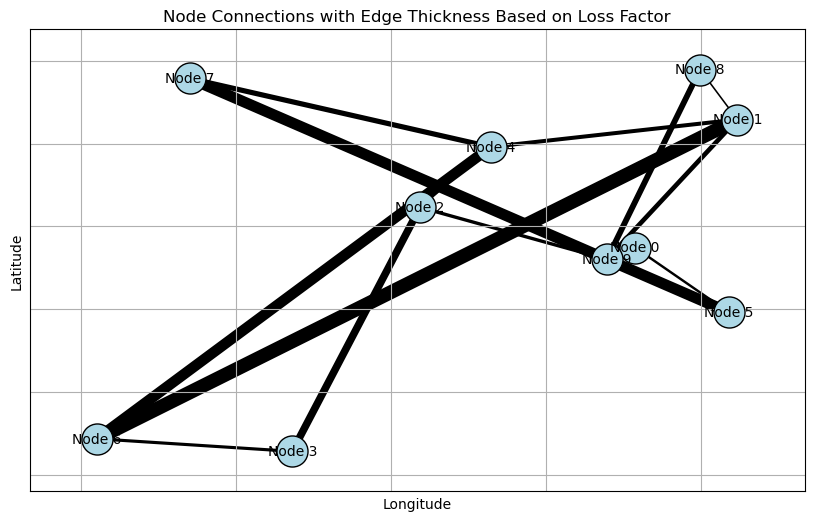

In [30]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming nodes and df_branches dataframes already exist
# Normalize the loss factors for plotting (so line thickness is relative)
df_branches['normalized_loss_factor'] = df_branches['loss_factor'] / df_branches['loss_factor'].max()

# Create a new graph for plotting
G_plot = nx.Graph()

# Add nodes to the graph
for idx, row in nodes.iterrows():
    G_plot.add_node(row['id'], pos=(row['lon'], row['lat']))

# Add edges to the graph with normalized loss factor for thickness
for _, row in df_branches.iterrows():
    G_plot.add_edge(row['node_from'], row['node_to'], weight=row['normalized_loss_factor'])

# Get positions of nodes (for plotting)
pos = {node_id: (data['pos'][0], data['pos'][1]) for node_id, data in G_plot.nodes(data=True)}

# Plot the nodes
plt.figure(figsize=(10, 6))
nx.draw_networkx_nodes(G_plot, pos, node_size=500, node_color='lightblue', edgecolors='black')

# Plot the edges with varying thickness based on the normalized loss factor
edges = G_plot.edges(data=True)
nx.draw_networkx_edges(G_plot, pos, edgelist=edges, width=[row['weight'] * 10 for u, v, row in edges])

# Add labels to the nodes
nx.draw_networkx_labels(G_plot, pos, labels={node_id: f'Node {node_id}' for node_id in G_plot.nodes()}, font_size=10)

# Title and display the plot
plt.title("Node Connections with Edge Thickness Based on Loss Factor")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()
